# K-Means Streaming

**[Get the data](#get_the_data)** <br>
**[Explore the data](#explore_the_data)** <br>
**[Clean the data](#clean_the_data)**<br>
**[Transform categorical features](#transform_categorical_features)** <br>
**[Features selection](#features_selection)** <br>
**[Features scaling](#features_scaling)**<br>
**[Prepare the data](#prepare_the_data)**<br>
**[PCA and visualization](#pca_and_visualisation)** <br>
**[K-Means](#kmeans)**<br>
**[Mini Batch K-Means](#mini_batch)** <br>
**[Streamig](#streaming)**<br>
**[K-Means with PCA](#kmeans_pca)**<br>
**[Mini Batch K-Means with PCA](#minibatch_pca)** <br>
**[Streamig with PCA](#streaming_pca)**<br> <br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.spatial import distance
from scipy import stats

## <a id='get_the_data'> Get the data </a>

In [2]:
dataset= pd.read_csv('processed.cleveland.data',header=None,names=['age','sex','cp','trestbps',
                    'chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'],index_col=None)

## <a id='explore_the_data'> Explore the data </a>

In [3]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null float64
sex         303 non-null float64
cp          303 non-null float64
trestbps    303 non-null float64
chol        303 non-null float64
fbs         303 non-null float64
restecg     303 non-null float64
thalach     303 non-null float64
exang       303 non-null float64
oldpeak     303 non-null float64
slope       303 non-null float64
ca          303 non-null object
thal        303 non-null object
num         303 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


 <font color=blue>Taille du dataset :</font> 303 <br>
<font color=blue>Les attributs: </font><br>
**age**: age in years<br>
**sex**: sex (1 = male; 0 = female)<br>
**cp**: chest pain type <br>
        - Value 1: typical angina
        - Value 2: atypical angina
        - Value 3: non-anginal pain
        - Value 4: asymptomatic<br>
**trestbps**:  resting blood pressure (in mm Hg on admission to the 
        hospital)<br>
**chol**: serum cholestoral in mg/dl<br>
**fbs**: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)<br>
**restecg**:  esting electrocardiographic results <br>
        - Value 0: normal
        - Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        - Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria<br>
**thalach**: maximum heart rate achieved<br>
**exang**: exercise induced angina (1 = yes; 0 = no)<br>
**oldpeak**: ST depression induced by exercise relative to rest<br>
**slope**: the slope of the peak exercise ST segment <br>
        - Value 1: upsloping
        - Value 2: flat
        - Value 3: downsloping <br>
**ca**: number of major vessels (0-3) colored by flourosopy<br>
**thal**: 3 = normal; 6 = fixed defect; 7 = reversable defect<br>
**num**:  diagnosis of heart disease (angiographic disease status) <br>
        - Value 0: < 50% diameter narrowing
        - Value 1: > 50% diameter narrowing<br>

In [5]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


## <a id='clean_the_data'> Clean data </a>

Le dataset contient **des valeurs nulles** représentées par des **?** dans le fichier, il faut donc les remplacer

/home/mina/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


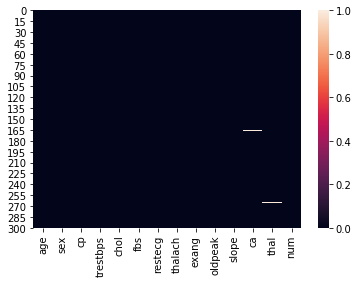

In [6]:
#visualiser les valeurs nulles
sns.heatmap(dataset=='?')

On remplace les valeurs nulles par **le mode**

In [7]:
# les valeurs nulles de l'attribut 'ca'
not_null_ca=[ float(c) for c in dataset['ca'] if c!="?"]
ca_mode=stats.mode(not_null_ca).mode[0]
dataset['ca']=dataset['ca'].apply(lambda x: str(ca_mode) if (x=='?') else x)

In [8]:
# les valeurs nulles de l'attribut 'thal'
not_null_thal=[ float(c) for c in dataset['thal'] if c!="?"]
thal_mode=stats.mode(not_null_thal).mode[0]
dataset['thal']=dataset['thal'].apply(lambda x: str(thal_mode) if (x=='?') else x)

In [9]:
dataset.apply(pd.to_numeric)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


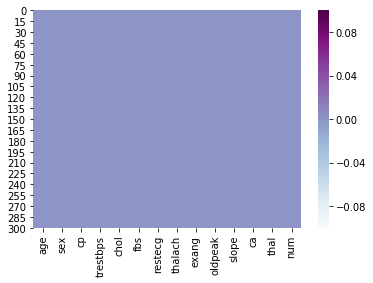

In [10]:
sns.heatmap(data= (dataset=="?"),cmap="BuPu")

## <a id='transform_categorical_features'> Transform categorical features </a>

le dataset contient des  attributs **categoriels** qu'il faut transformer <br>
Il s'agit des colonnes:  **'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca'** et  **'thal'**

In [11]:
dataset= pd.get_dummies(dataset, columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'],drop_first=True)

In [12]:
dataset.head()

,age,trestbps,chol,thalach,oldpeak,num,sex_1.0,cp_2.0,cp_3.0,cp_4.0,...,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,63.0,145.0,233.0,150.0,2.3,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,67.0,160.0,286.0,108.0,1.5,2,1,0,0,1,...,0,1,1,1,0,0,0,1,0,0
2,67.0,120.0,229.0,129.0,2.6,1,1,0,0,1,...,0,1,1,1,0,0,1,0,0,1
3,37.0,130.0,250.0,187.0,3.5,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,41.0,130.0,204.0,172.0,1.4,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


## <a id='features_scaling'> Features Scaling </a>

Comme la gamme de valeurs des données brutes varie considérablement,une **normalisation** des données est nécessaire 
<br>

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler= StandardScaler()

In [15]:
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])

In [16]:
dataset.head()

,age,trestbps,chol,thalach,oldpeak,num,sex_1.0,cp_2.0,cp_3.0,cp_4.0,...,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,0.948726,0.757525,-0.264900,0.017197,1.087338,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,1.392002,1.611220,0.760415,-1.821905,0.397182,2,1,0,0,1,...,0,1,1,1,0,0,0,1,0,0
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1,1,0,0,1,...,0,1,1,1,0,0,1,0,0,1
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


## <a id='prepare_data'>Prepare data </a>

In [17]:
X= dataset.drop('num',axis=1)
X.head()

,age,trestbps,chol,thalach,oldpeak,sex_1.0,cp_2.0,cp_3.0,cp_4.0,fbs_1.0,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,0.948726,0.757525,-0.264900,0.017197,1.087338,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0
1,1.392002,1.611220,0.760415,-1.821905,0.397182,1,0,0,1,0,0,1,1,1,0,0,0,1,0,0
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1,0,0,1,0,0,1,1,1,0,0,1,0,0,1
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [18]:
y= dataset['num'].apply(lambda x: 0 if x==0 else 1)
y.head()

0    0
1    1
2    1
3    0
4    0
Name: num, dtype: int64

## <a id='features_selection'>Features selection </a>

In [19]:
from sklearn.feature_selection import mutual_info_classif

In [20]:
dataset.corrwith(dataset['num'])

age            0.222853
trestbps       0.157754
chol           0.070909
thalach       -0.415040
oldpeak        0.504092
num            1.000000
sex_1.0        0.224469
cp_2.0        -0.238240
cp_3.0        -0.284135
cp_4.0         0.490494
fbs_1.0        0.059186
restecg_1.0    0.123792
restecg_2.0    0.168387
exang_1.0      0.397057
slope_2.0      0.344230
slope_3.0      0.119900
ca_1.0         0.144712
ca_2.0         0.311855
ca_3.0         0.295362
thal_6.0       0.103916
thal_7.0       0.466119
dtype: float64

In [21]:
res = dict(zip(dataset.drop('num',axis=1).columns, mutual_info_classif(dataset.drop('num',axis=1), y)))
res

{'age': 0.007823122903267032,
 'trestbps': 0.0,
 'chol': 0.0831719947867926,
 'thalach': 0.08415483664124102,
 'oldpeak': 0.13204895648434611,
 'sex_1.0': 0.00020563488386526885,
 'cp_2.0': 0.021282363102985702,
 'cp_3.0': 0.0,
 'cp_4.0': 0.12821651561539338,
 'fbs_1.0': 0.0,
 'restecg_1.0': 0.06141656967522269,
 'restecg_2.0': 0.04959907382307338,
 'exang_1.0': 0.1019729199274968,
 'slope_2.0': 0.07505802794176986,
 'slope_3.0': 0.0031588299818394727,
 'ca_1.0': 0.04276252532228497,
 'ca_2.0': 0.027827988390947356,
 'ca_3.0': 0.05481697334752078,
 'thal_6.0': 0.0027669318176641866,
 'thal_7.0': 0.12001741205601024}

In [22]:
dataset= dataset[['cp_4.0','ca_2.0','thal_7.0', 'oldpeak','thalach','thalach','chol', 'sex_1.0','restecg_1.0','exang_1.0','slope_2.0','num']]

In [23]:
dataset.head()

,cp_4.0,ca_2.0,thal_7.0,oldpeak,thalach,thalach,chol,sex_1.0,restecg_1.0,exang_1.0,slope_2.0,num
0,0,0,0,1.087338,0.017197,0.017197,-0.264900,1,0,0,0,0
1,1,0,0,0.397182,-1.821905,-1.821905,0.760415,1,0,1,1,2
2,1,1,1,1.346147,-0.902354,-0.902354,-0.342283,1,0,1,1,1
3,0,0,0,2.122573,1.637359,1.637359,0.063974,1,0,0,0,0
4,0,0,0,0.310912,0.980537,0.980537,-0.825922,0,0,0,0,0


## <a id= 'pca_and_visualisation'>PCA and visualization </a>

Comme les données ont une très grande dimension on ne peut pas visualiser notre dataset, donc on fait appel à l'ACP pour **réduire la dimension** afin de pouvoir visualiser les données <br> <br>

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca= PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)

Text(0, 0.5, 'Second Principal Component')

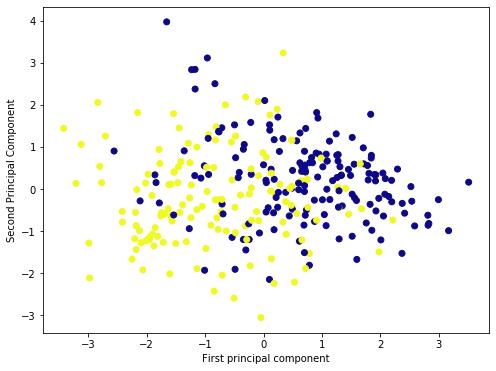

In [26]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=y,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

## <a id= 'kmeans' >Kmeans </a>

Partionner les données en 2 classe en utilisant le modèle **K-Means** avec **K=2**

In [27]:
from sklearn.cluster import MiniBatchKMeans,KMeans
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
kmeans= KMeans(n_clusters=2,init='random',random_state=42)

In [73]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=2,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [74]:
kmeans.cluster_centers_

array([[-5.81531480e-01, -2.76394272e-01, -1.86682083e-01,
         5.96984979e-01, -4.94802985e-01,  6.85185185e-01,
         2.65432099e-01,  3.64197531e-01,  3.08641975e-01,
         1.17283951e-01,  6.93889390e-18,  3.95061728e-01,
         1.60493827e-01,  2.65432099e-01,  4.93827160e-02,
         1.48148148e-01,  5.55555556e-02,  3.08641975e-02,
         3.08641975e-02,  2.71604938e-01],
       [ 6.68142551e-01,  3.17559376e-01,  2.14485797e-01,
        -6.85897635e-01,  5.68497046e-01,  6.73758865e-01,
         4.96453901e-02,  1.91489362e-01,  6.66666667e-01,
         1.84397163e-01,  2.83687943e-02,  5.95744681e-01,
         5.17730496e-01,  6.87943262e-01,  9.21985816e-02,
         2.90780142e-01,  2.05673759e-01,  1.06382979e-01,
         9.21985816e-02,  5.17730496e-01]])

In [75]:
print(classification_report(y,kmeans.labels_))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       164
           1       0.71      0.72      0.71       139

    accuracy                           0.74       303
   macro avg       0.73      0.73      0.73       303
weighted avg       0.74      0.74      0.74       303



In [76]:
print (confusion_matrix(y,kmeans.labels_))

[[123  41]
 [ 39 100]]


Text(0, 0.5, 'Second Principal Component')

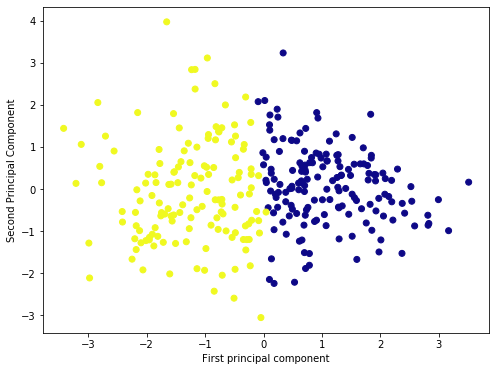

In [77]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=kmeans.labels_,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

Pour le **K-Means** nous avons obtenu:
- **accuracy**= 75%
- **f1-score pour classe 0**:  78%
- **f1-score pour classe 1**:  71%

## <a id = 'mini_batch'> Mini batch kmeans</a>

Partionner les données en 2 classe en utilisant le modèle **Mini Batch K-Means** avec **K=2** <br>
L'algorithme prend de **petits batch** (choisis aléatoirement) du dataset pour chaque itération. Il affecte ensuite une grappe à chaque point de données du lot, en fonction des emplacements précédents des centroïdes de la grappe. Il met ensuite à jour les emplacements des centroïdes de cluster en fonction des nouveaux points du lot.
<br> <br>
Pour simuler le **K-Means en streaming** on prend la **taille du batch=1**
<br><br>

In [100]:
minibatch= MiniBatchKMeans(n_clusters=2,batch_size=1,init='random',random_state=10)

In [101]:
minibatch.fit(X)

MiniBatchKMeans(batch_size=1, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=10,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [102]:
print (classification_report(y,minibatch.labels_))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       164
           1       0.75      0.79      0.77       139

    accuracy                           0.78       303
   macro avg       0.78      0.78      0.78       303
weighted avg       0.78      0.78      0.78       303



In [85]:
print (confusion_matrix(y,minibatch.labels_))

[[163   1]
 [137   2]]


Text(0, 0.5, 'Second Principal Component')

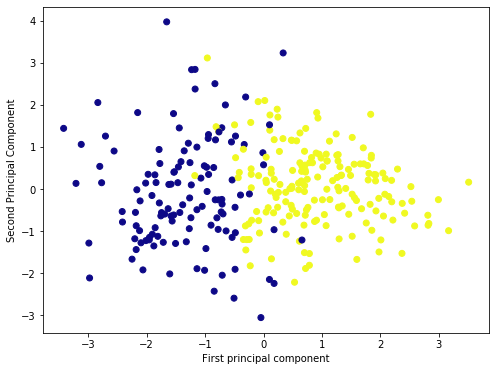

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=minibatch.labels_,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

Pour le **K-Means** nous avons obtenu:
- **accuracy**= 74%
- **f1-score pour classe 0**:  75%
- **f1-score pour classe 1**:  72%

##  <a id= 'streaming'>Streaming </a>

Nous avons implémenter un algorithme pour simuler le Streaming <br>
**Etape 1:**  Faire de l'apprentissage sur un premier batch de données (supposant 100 individus) <br>
**Etape 2:** Faire de l'apprentissage pour chaque nouvel individu: <br>
- Prendre les centroids de la première étape.
- initialiser n0 ,n1,..., nk tel que ni est le nombre d'individus affectés à la classe i
- Répéter pour chaque nouvel individu x: <br>
-- affecter x à la classe dont le centre est plus proche mi <br> 
-- mettre à jour mi telque mi= mi+ (1/ni)* (x-mi) <br>

In [112]:
stream= KMeans(n_clusters=2,init='random',random_state=101)

In [113]:
stream.fit((X.loc[0:100,:]))

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=2,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=101,
       tol=0.0001, verbose=0)

In [114]:
centers= stream.cluster_centers_
centers

array([[-2.50297251e-01, -1.00382160e-03,  1.04568471e-01,
         5.75675805e-01, -3.65101833e-01,  6.39344262e-01,
         2.13114754e-01,  4.59016393e-01,  2.95081967e-01,
         1.31147541e-01,  0.00000000e+00,  4.91803279e-01,
         9.83606557e-02,  1.96721311e-01,  8.19672131e-02,
         1.63934426e-01,  4.91803279e-02, -2.77555756e-17,
         4.91803279e-02,  1.63934426e-01],
       [ 4.36189247e-01,  1.86972319e-01, -1.61401476e-01,
        -5.60806358e-01,  9.55776989e-01,  8.25000000e-01,
        -8.32667268e-17,  1.75000000e-01,  7.00000000e-01,
         1.25000000e-01,  0.00000000e+00,  7.00000000e-01,
         6.00000000e-01,  6.75000000e-01,  1.50000000e-01,
         2.50000000e-01,  2.25000000e-01,  1.25000000e-01,
         5.00000000e-02,  7.00000000e-01]])

In [115]:
n0=stream.labels_[stream.labels_==0].size

In [116]:
n1=stream.labels_[stream.labels_==1].size

In [117]:
def get_class(x,centeroids,k):
    class_name=0
    dist=float('inf')
    for i in range (0,k):
        d= distance.euclidean(x,centeroids[i],2)
        if (d<dist):
            dist=d
            class_name= i
    return class_name
    

In [118]:
labels= list(stream.labels_)
print (len(labels))
for pts in np.array(X.loc[101:,:]):
    class_name= get_class(np.array(pts),centers,2)
    
    if class_name==0:
        labels.append(0)
        n0+=1
        centers[0]=centers[0]+(1/n0)*(np.array(pts)-centers[0])
    else:
        n1+=1
        centers[0]=centers[0]+(1/n0)*(np.array(pts)-centers[0])
        labels.append(1)


101


In [119]:
print(classification_report(y,labels))

              precision    recall  f1-score   support

           0       0.73      0.87      0.80       164
           1       0.81      0.63      0.70       139

    accuracy                           0.76       303
   macro avg       0.77      0.75      0.75       303
weighted avg       0.77      0.76      0.75       303



In [120]:
print (confusion_matrix(y, labels))

[[143  21]
 [ 52  87]]


Text(0, 0.5, 'Second Principal Component')

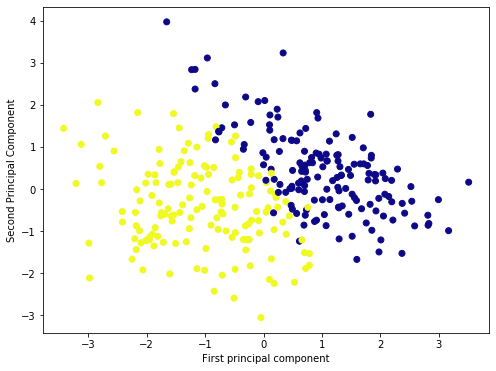

In [121]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=minibatch.labels_,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

Pour le **K-Means** nous avons obtenu:
- **accuracy**= 74%
- **f1-score pour classe 0**:  78%
- **f1-score pour classe 1**:  69%

## <a id= 'kmeans_pca'> K-Means with PCA</a>

Maintenant on teste le partitionnement K-Means après la réduction des dimensions

In [52]:
kmeans_pca= MiniBatchKMeans(n_clusters=2,batch_size=1,init='random',random_state=42)

In [53]:
kmeans_pca.fit(x_pca)

MiniBatchKMeans(batch_size=1, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [54]:
print (classification_report(y,kmeans_pca.labels_))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       164
           1       0.79      0.60      0.68       139

    accuracy                           0.74       303
   macro avg       0.75      0.73      0.73       303
weighted avg       0.75      0.74      0.74       303



In [56]:
print (confusion_matrix(y,kmeans_pca.labels_))

[[141  23]
 [ 55  84]]


Text(0, 0.5, 'Second Principal Component')

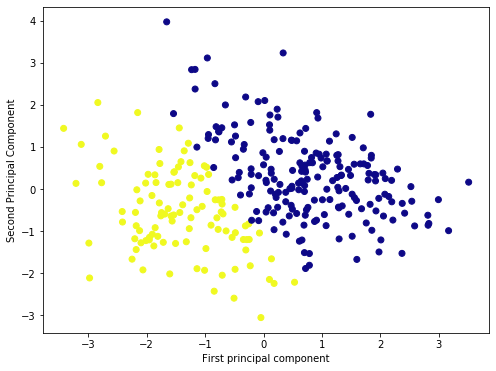

In [57]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=kmeans_pca.labels_,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

Pour le **K-Means après PCA** nous avons obtenu:
- **accuracy**= 72%
- **f1-score pour classe 0**:  76%
- **f1-score pour classe 1**:  68%

##  <a id ='minibatch_pca'>Mini Batch K-Means with PCA</a>

In [122]:
minibatch_pca= MiniBatchKMeans(n_clusters=2,batch_size=1,init='random',random_state=10)

In [123]:
minibatch_pca.fit(x_pca)

MiniBatchKMeans(batch_size=1, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=10,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [124]:
print (classification_report(y,minibatch_pca.labels_))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       164
           1       0.78      0.70      0.73       139

    accuracy                           0.77       303
   macro avg       0.77      0.76      0.77       303
weighted avg       0.77      0.77      0.77       303



In [62]:
print (confusion_matrix(y,minibatch_pca.labels_))

[[ 34 130]
 [ 37 102]]


Text(0, 0.5, 'Second Principal Component')

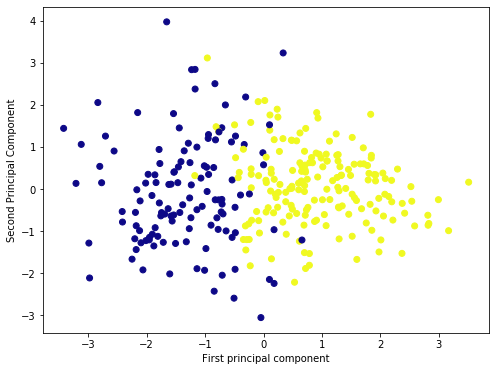

In [63]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=minibatch.labels_,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

Pour le **K-Means après PCA** nous avons obtenu:
- **accuracy**= 70%
- **f1-score pour classe 0**:  72%
- **f1-score pour classe 1**:  68%

## <a id="streaming_pca">Streaming with pca</a>

In [131]:
pca_stream= KMeans(n_clusters=2,init='random',random_state=10)
pca_stream.fit((x_pca[0:100,:]))
centers= pca_stream.cluster_centers_
centers

array([[ 0.70534791,  0.45123162],
       [-1.18209584, -0.52286305]])

In [132]:
n0=pca_stream.labels_[pca_stream.labels_==0].size
n1=pca_stream.labels_[pca_stream.labels_==1].size


In [133]:
labels= list(pca_stream.labels_)
print (len(labels))

100


In [134]:
for pts in np.array(x_pca[100:,:]):
    class_name= get_class(np.array(pts),centers,2)
    
    if class_name==0:
        labels.append(0)
        n0+=1
        centers[0]=centers[0]+(1/n0)*(np.array(pts)-centers[0])
    else:
        n1+=1
        centers[0]=centers[0]+(1/n0)*(np.array(pts)-centers[0])
        labels.append(1)



In [135]:
len(labels)

303

In [136]:
print(classification_report(y,labels))

              precision    recall  f1-score   support

           0       0.74      0.85      0.80       164
           1       0.79      0.65      0.72       139

    accuracy                           0.76       303
   macro avg       0.77      0.75      0.76       303
weighted avg       0.77      0.76      0.76       303



In [70]:
print (confusion_matrix(y, labels))

[[ 39 125]
 [105  34]]


Text(0, 0.5, 'Second Principal Component')

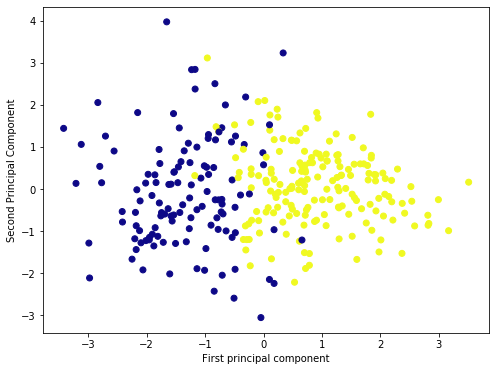

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=minibatch.labels_,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

Pour le **K-Means en streaming après ACP** nous avons obtenu:
- **accuracy**= 71%
- **f1-score pour classe 0**:  70%
- **f1-score pour classe 1**:  72%